---
title: "Adam optimizer with annealing learning rate"
author: "Alex Kelly"
date: "2023-12-28"
format:
  html:
    code-fold: false
    toc : true
    numbered-sections : true
jupyter : python3
draft : True
---

# Overview

A neural network is a machine learning model that is inspired by the human brain. A human brain is collection of neurons that are connected to each other by synapses and electrical pulses travel between.  This consist of a input, say reading a book and the neural network will respond by firing up the relevent neruanons that deal reading text and makes sense of the text (the thinking process) and giving a output, e.g. giving a sumarry of the text read.  An artificial neural network (ann) is a collection of artificial neurons that are connected to each other in a particular archtechure that exists on a computer.  A example ANN arcitecture could be a  CNN (converlutiohn neural network) or a RNN (Recurrent Neural Network ) or a combination of these layers and many others. In the notebooks case, the model will take in a sequences of pixels (an image) and output a sequence of pixels (an image) using sequential CNNs.



In [184]:
!["Human neural network vs artificial neural network"]("https://clevertap.com/wp-content/uploads/2019/04/Neural_Network_Brain_Mimic.jpeg")

'["Human neural network vs artificial neural network"]' is not recognized as an internal or external command,
operable program or batch file.




The archtechure of the model is a type of convolutional neural network (CNN) and it consists of five main blocks, each containing a sequence of layers.

1. The first block starts with a Conv2d layer with 1 input channel and 8 output channels, followed by a BatchNorm2d layer and a GeneralRelu (generalized ReLU) activation function.
2. The second block is similar to the first, but it starts with a Conv2d layer with 8 input channels and 16 output channels.
3. The third block starts with a Conv2d layer with 16 input channels and 32 output channels, followed by the same sequence of BatchNorm2d and GeneralRelu layers.
4. The fourth block starts with a Conv2d layer with 32 input channels and 64 output channels, followed by the same sequence of BatchNorm2d and GeneralRelu layers.
5. The fifth block contains only a Conv2d layer with 64 input channels and 10 output channels.

Finally, the model includes a Flatten layer to convert the 2D output of the previous layers into a 1D vector for further processing or output.

The the convolutions help compress the image into a smaller and smaller sizes and the model can learn the important features of the image. The model on the last layer will then use the features to make a prediction.

## What is a optimizer in deep learning and why it is important?

An optimizer is a method to update the weights of the neural network to minimize the loss function.  A loss function is a measure between the predicted output and the actual output. In simple terms the closer these two are the better the model will perform, you will get what you expect from the model.  The weights are updated by using the gradient of the loss function.  The gradient is the slope of the loss function.  It can be thought of as the direction the weights should be updated.  If the gradient is positive then the weights should be increased.  If the gradient is negative then the weights should be decreased.  If the weights are increased/descreesed by too much then the model will over shoot and not get you closer to the actual output.  The aim of the optimizer is to get to the smallest loss possible in the quickest amount of time or with the least amount of processing power.

## Adam optimizer with annealing learning rate

The aim of this blog is to show how to use the Adam optimizer with annealing learning rate. The Adam optimizer is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments. The Adam optimizer is one of the most popular optimizers used in deep learning. The annealing learning rate is used to prevent the model from overfitting and is also used to speed up the training process.

# Setup enviroment

In [8]:
import os 
import sys

In [9]:
# checks if the environment is local or remote
def check_if_local():
    # Checking for common remote environment indicators
    remote_indicators = ['COLAB_GPU', 'JUPYTERHUB_SERVICE_PREFIX']

    # If any of the indicators are present, it's likely not a local environment
    if any(indicator in os.environ for indicator in remote_indicators):
        return False
    else:
        # Assuming local environment if none of the remote indicators are found
        return True


In [10]:
# checks if the environment is local or remote and sets the path accordingly 
if check_if_local() == False:
    print('Running in a remote environment, mounting Google Drive...')
    from google.colab import drive
    drive.mount('/content/drive')
    sys.path.append('/content/drive/MyDrive/Learning/data_science/')
    !pip install datasets
else :
    print('Running in a local environment...')
    sys.path.append('G:\My Drive\Learning\data_science')


Running in a local environment...


In [11]:
import os
import sys
import pickle,gzip,math,os,time,shutil,torch,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *

c:\ProgramData\anaconda3\envs\basic_data_science_libraries\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Get the data 

In [12]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

set_seed(42)
xl,yl = 'image','label'
name = "fashion_mnist"
dsd = load_dataset(name)

bs = 1024
xmean,xstd = 0.28, 0.35

@inplace
def transformi(b): b[xl] = [(TF.to_tensor(o)-xmean)/xstd for o in b[xl]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=0)

# Setup the call backs 

In [41]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
lrf_cbs = [DeviceCB(), LRFinderCB()]

# The mini AI learner class and how the optimizer runs 


We are using the MiniAI custom trainer class.  It enables you to train deep learning models, in our case pytorch models.  Its very dynanamic and enables you to add callbacks (custom peices of code) to various parts of the training process. This creates a flexible system where you can add, swap and experiment in a quick, easy and repeatably way. In summary its very flexiable trainer class.

The mini AI learner class takes in the model, the data, the optimizer class (how to minimize the loss), the loss function (how to calculate the loss), the number of epochs (how many times to train the model on the data), the learning rate and any call backs.  For the next few trainings runs we will use a varient of the learner class called TrainLeaner, the only difference between learner and trainlearner is it explicitly adds the following functions rather than passing them as callbacks.

1. predict 
2. get_loss
3. backward
4. step
5. zero_grad

The first step is to create an instance of the TrainLearner class and next step is to call the fit method to start the training. In summary it will:

1. Pass the first batch of data to the model
2. Calculate the loss on the model
3. Perform back propergation to figure out the gradient
4. Run the opimizer (e.g. SGD or ADAM) to figure out how to reduce the loss in the most optimized way
5. Zero's the gradients for all the parameters (Most models accumilates the gradients so zero'ing is important to get the correct result)
6. Repeat 1 to 5 until until you've been through the data as many times as specified in the epochs parameter in the hope that the model has learned the features of the data and can give a good prediction. 

A more detailed diagram is listend below.

```{mermaid}
flowchart TD
    A(Start) --> B[fit]
    B -->|Set epochs, opt func, etc.| C[_fit]
    C -->|For each epoch| D[one_epoch for Training]
    C -->|For each epoch| E[one_epoch for Validation]
    D --> F{_one_batch for each batch in Training}
    E --> G{_one_batch for each batch in Validation}
    F --> H[predict]
    G --> H
    H --> I[get_loss]
    I -->|If Training| J[backward]
    I -->|If Validation| K(End of batch processing)
    J --> L[step]
    L --> M[zero_grad]
    M --> K

    subgraph SGD Optimizer
        L -->|opt_step| N(Update params with lr and gradient)
        L -->|reg_step| O(Update params with weight decay)
        M --> P(Reset gradients)
    end

    subgraph TrainLearner Methods
        H --> Q(Predict: Model forward pass)
        I --> R(Calculate Loss)
        J --> S(Backward: Compute gradient)
        L --> T(Step: Update weights)
        M --> U(Zero_grad: Clear gradients)
    end
```

The diagram below shows a higher level view of the class diagram of the learner module and the optimizer module.

```{mermaid}
classDiagram
    class Learner {
        +model
        +dls
        +loss_func
        +lr
        +cbs
        +opt_func
        +_one_batch()
        +_one_epoch()
        +one_epoch(training)
        +_fit(train, valid)
        +fit(n_epochs, train, valid, cbs, lr)
        +callback(method_nm)
    }
    class TrainLearner {
        +predict()
        +get_loss()
        +backward()
        +step()
        +zero_grad()
    }
    class SGD {
        +params
        +lr
        +wd
        +step()
        +opt_step(p)
        +reg_step(p)
        +zero_grad()
    }

    Learner <|-- TrainLearner
    Learner --o SGD : uses >>

    TrainLearner : override predict()
    TrainLearner : override get_loss()
    TrainLearner : override backward()
    TrainLearner : override step()
    TrainLearner : override zero_grad()

    Learner : fit() --> _fit()
    Learner : _fit() --> one_epoch()
    Learner : one_epoch() --> _one_batch()
    Learner : _one_batch() --> callback()
    Learner : _one_batch() --> (if training) backward()
    Learner : backward() --> step()
    Learner : step() --> zero_grad()
    
    SGD : step() --> opt_step()
    SGD : step() --> reg_step()
    SGD : zero_grad() --> reset gradients
```

In [72]:
# The learner class expects the following fucntions to be passed as a callback : predict, get_loss, backward, step, zero_grad. 
class Learner():
    def __init__(self, model, dls=(0,), loss_func=F.mse_loss, lr=0.1, cbs=None, opt_func=optim.SGD):
        cbs = fc.L(cbs)
        fc.store_attr()

    @with_cbs('batch')
    def _one_batch(self):
        self.predict()
        self.callback('after_predict')
        self.get_loss()
        self.callback('after_loss')
        if self.training:
            self.backward()
            self.callback('after_backward')
            self.step()
            self.callback('after_step')
            self.zero_grad()

    @with_cbs('epoch')
    def _one_epoch(self):
        for self.iter,self.batch in enumerate(self.dl): self._one_batch()

    def one_epoch(self, training):
        self.model.train(training)
        self.dl = self.dls.train if training else self.dls.valid
        self._one_epoch()

    @with_cbs('fit')
    def _fit(self, train, valid):
        for self.epoch in self.epochs:
            if train: self.one_epoch(True)
            if valid: torch.no_grad()(self.one_epoch)(False)
            
    def fit(self, n_epochs=1, train=True, valid=True, cbs=None, lr=None):
        cbs = fc.L(cbs)
        # `add_cb` and `rm_cb` were added in lesson 18
        for cb in cbs: self.cbs.append(cb)
        try:
            self.n_epochs = n_epochs
            self.epochs = range(n_epochs)
            if lr is None: lr = self.lr
            if self.opt_func: self.opt = self.opt_func(self.model.parameters(), lr)
            self._fit(train, valid)
        finally:
            for cb in cbs: self.cbs.remove(cb)

    def __getattr__(self, name):
        if name in ('predict','get_loss','backward','step','zero_grad'): return partial(self.callback, name)
        raise AttributeError(name)

    def callback(self, method_nm): run_cbs(self.cbs, method_nm, self)
    
    @property
    def training(self): return self.model.training

In [73]:
# The Trainer class inherits all the classes from Leaner but explicitly adds 
# predict, get_loss, backward, step, zero_grad classes functions  

class TrainLearner(Learner):
    def predict(self): self.preds = self.model(self.batch[0])
    def get_loss(self): self.loss = self.loss_func(self.preds, self.batch[1])
    def backward(self): self.loss.backward()
    def step(self): self.opt.step()
    def zero_grad(self): self.opt.zero_grad()

# The optimizers

We will start of with one of the simplest optimizers and build up, taking in the results and how they improve as we introduce more affective optimisers.  We will cover SGD, Adam, Adam with Automatic Annealer, and then introduce Adam with Automatic Annealing as a call back.  Abit about each of the optimizers:

- **SGD** is a simple optimizer that takes in the learning rate and the model parameters and updates the model parameters by subtracting the learning rate multiplied by the gradient of the loss function.  The learning rate is a hyperparameter that needs to be tuned to get the best results.  If the learning rate is too high then the model will overshoot and not get to the minimum loss.  If the learning rate is too low then the model will take a long time to get to the minimum loss.  The learning rate is a constant and does not change during the training process.

- **Adam** is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.  It is one of the most popular optimizers used in deep learning.  It is a adaptive learning rate optimizer that uses the first and second moments of the gradient to update the model parameters.  The first moment is the mean of the gradient and the second moment is the uncentered variance of the gradient.  The first moment is used to calculate the direction of the gradient and the second moment is used to calculate the size of the gradient.  The Adam optimizer has three hyperparameters that need to be tuned to get the best results.  The first hyperparameter is the learning rate.  The second hyperparameter is the beta1 which is the exponential decay rate for the first moment.  The third hyperparameter is the beta2 which is the exponential decay rate for the second moment.  The learning rate is a constant and does not change during the training process.  The beta1 and beta2 are constants and do not change during the training process.

- **Adam with Automatic Annealing** is a Adam optimizer that uses a learning rate that changes during the training process.  The learning rate is a hyperparameter that needs to be tuned to get the best results.  If the learning rate is too high then the model will overshoot and not get to the minimum loss.  If the learning rate is too low then the model will take a long time to get to the minimum loss.  The learning rate is a constant and does not change during the training process.

The SGD optimizer class is a simple class that takes in params, learning rate (lr), and weight decay.  It has 4 functions step, opt_step, reg_step and zero_grad.  The key function relating to TrainLearner is the step function which calls opt_step (updates the parameters from the learning rate) and reg_step (updates parameters from the weight decay if given).

Zero_grad is called after every batch to zero the gradients, by default in pytorch they acculmtate which isnt desired.

In [43]:
# SGD optimizer is a type of gradient descent optimizer.  It is a first order optimizer (only uses the first derivative)
# It is a stochastic optimizer (it uses a random sample of the data to calculate the gradient)

class SGD:
    def __init__(self, params, lr, wd=0.):
        """
        Initializes the SGD  optimizer.

        Args:
            params (iterable): Iterable of parameters to optimize.
            lr (float): Learning rate.
            wd (float, optional): Weight decay (default: 0).

        """
        params = list(params)
        fc.store_attr()
        self.i = 0
    # calculates the parameters and weight decays. Step occurs after the backward pass (when the gradients are calculated)  
    def step(self):
        # calls torch.no_grad() to disable gradient tracking
        with torch.no_grad():
            # iterates over the parameters
            for p in self.params:
                self.reg_step(p)
                self.opt_step(p)
        self.i +=1
        
    # Updates the parameters using the gradient and the learning rate
    def opt_step(self, p): p -= p.grad * self.lr
    
    # Calculates the weight decay and updates the parameters
    # The purpose of weight decay is to prevent overfitting. It is calculated by multiplying the learning rate by the weight decay
    # essentially it is a penalty for having large weights (it reduces the value of the weights)
    def reg_step(self, p):
        if self.wd != 0: p *= 1 - self.lr*self.wd

    # Zeros out the gradient for all parameters.  This is useful because the gradients are accumulated by default (useful for RNNs)
    def zero_grad(self):
        for p in self.params: p.grad.data.zero_()

accuracy,loss,epoch,train
0.307,2.016,0,train
0.479,1.654,0,eval
0.567,1.442,1,train
0.617,1.283,1,eval
0.658,1.168,2,train
0.676,1.089,2,eval


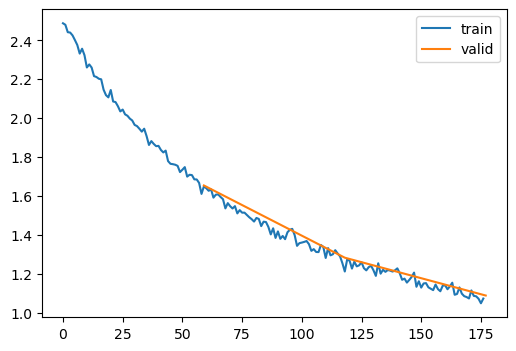

In [44]:
set_seed(42)                                             # sets the seed for reproducibility 
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw) # gets the model and applies the init_weights function

# creates the learner object and passes the model, dataloaders (the data), loss function, learning rate,
# callbacks and optimizer function
learn = TrainLearner(model, dls, F.cross_entropy, lr=6e-3, cbs=cbs, opt_func=SGD)   
learn.fit(3)                                             # fits the model for 3 epochs

### Adam 

Adam optimizer is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments. Its a combination of RMSprop and momentum and commonly used in deep learning.

Some good references to 1st order and 2nd order moments are 

- https://www.mathsisfun.com/calculus/second-derivative.html
- https://www.mathsisfun.com/calculus/second-derivative-animation.html

In [16]:
class Adam(SGD):
    def __init__(self, params, lr, wd=0., beta1=0.9, beta2=0.99, eps=1e-5):
        super().__init__(params, lr=lr, wd=wd)
        self.beta1,self.beta2,self.eps = beta1,beta2,eps

    def opt_step(self, p):
        if not hasattr(p, 'avg'): p.avg = torch.zeros_like(p.grad.data)
        if not hasattr(p, 'sqr_avg'): p.sqr_avg = torch.zeros_like(p.grad.data)
        p.avg = self.beta1*p.avg + (1-self.beta1)*p.grad
        unbias_avg = p.avg / (1 - (self.beta1**(self.i+1)))
        p.sqr_avg = self.beta2*p.sqr_avg + (1-self.beta2)*(p.grad**2)
        unbias_sqr_avg = p.sqr_avg / (1 - (self.beta2**(self.i+1)))
        p -= self.lr * unbias_avg / (unbias_sqr_avg + self.eps).sqrt()

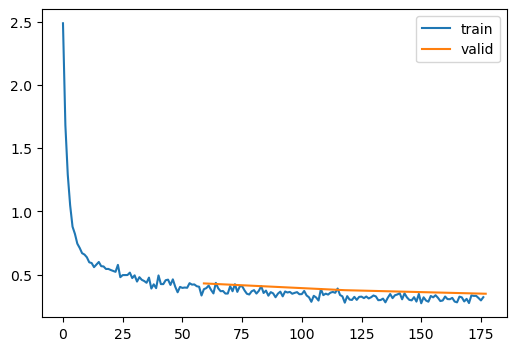

In [17]:
# first run with adam as the optimizer
set_seed(42)                                                # sets the seed for reproducibility 
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)    # gets the model and applies the init_weights function

# creates the learner object and passes the model, dataloaders (the data), loss function, learning rate,
# callbacks and optimizer function
learn = TrainLearner(model, dls, F.cross_entropy, lr=6e-3, cbs=cbs, opt_func=Adam)
learn.fit(3)                                                # fits the model for 3 epochs

# Adam with Automatic Annealer

Automatic annealing refers to the automatic adjustment of the learning rate during training. Unlike a constant or step-wise decayed learning rate, automatic annealers adjust the learning rate based on the model's performance, generally on the validation set. Criteria such as validation loss, training loss, or some other metric can be used for this adjustment.
<br><br>
For instance, if the validation loss plateaus or increases, the annealer may reduce the learning rate, effectively "cooling down" the optimization and allowing the model to escape local minima or saddle points. Conversely, if the model is learning effectively, the annealer might maintain or even slightly increase the learning rate.

In [22]:
# Run with adam with annealing as the optimizer 
class AdamWithAnnealing(SGD):
    def __init__(self, params, lr, wd=0., beta1=0.9, beta2=0.99, eps=1e-5, anneal_rate=0.97):
        super().__init__(params, lr=lr, wd=wd)
        self.beta1, self.beta2, self.eps = beta1, beta2, eps
        self.anneal_rate = anneal_rate

    def opt_step(self, p):
        if not hasattr(p, 'avg'): p.avg = torch.zeros_like(p.grad.data)
        if not hasattr(p, 'sqr_avg'): p.sqr_avg = torch.zeros_like(p.grad.data)
        
        # Update averages
        p.avg = self.beta1 * p.avg + (1 - self.beta1) * p.grad
        unbias_avg = p.avg / (1 - (self.beta1**(self.i + 1)))
        p.sqr_avg = self.beta2 * p.sqr_avg + (1 - self.beta2) * (p.grad**2)
        unbias_sqr_avg = p.sqr_avg / (1 - (self.beta2**(self.i + 1)))

        # Apply annealing to learning rate
        annealed_lr = self.lr * (self.anneal_rate ** self.i)

        # Update parameters
        p -= annealed_lr * unbias_avg / (unbias_sqr_avg.sqrt() + self.eps)


In [23]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)
lrf_cbs = [DeviceCB(), LRFinderCB()]

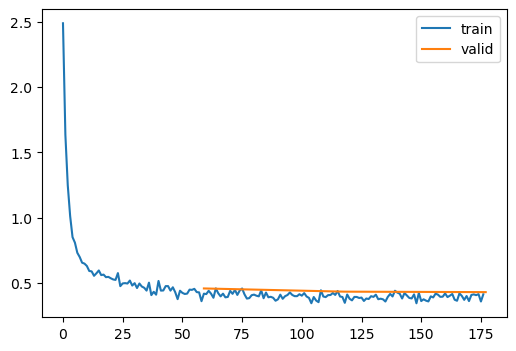

In [20]:
set_seed(42)                                               # sets the seed for reproducibility
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)   # gets the model and applies the init_weights function

# creates the learner object and passes the model, dataloaders (the data), loss function, learning rate,
# callbacks and optimizer function
learn = TrainLearner(model, dls, F.cross_entropy, lr=6e-3, cbs=cbs, opt_func=AdamWithAnnealing)
learn.fit(3)                                               # fits the model for 3 epochs

# The Calls backs 

To create a call back, i will demostrate it on the simplest of optimizers, the SGD optimizer and repeat the process on the Adam with annealing. 

We will create a callbackclass from TrainCB which has the following methods: 

- predict
- get_loss
- backward
- step
- zero_grad

We will be replacing step, and adding opt_step and reg_step.  The step function is called after the backward function and before the zero_grad function.  The step function is used to update the model parameters.  The opt_step function is used to update the model parameters from the learning rate.  The reg_step function is used to update the model parameters from the weight decay if given.  The zero_grad function is used to zero the gradients.

In [187]:

class SGDCallback_TrainCB(TrainCB):
    def __init__(self, lr, wd=0., n_inp=1): 
        self.n_inp = n_inp
        fc.store_attr()
        self.i = 0
        # calculates the parameters and weight decays. Step occurs after the backward pass (when the gradients are calculated)  
    def step(self, learn): 
        # calls torch.no_grad() to disable gradient tracking
        with torch.no_grad():
            # iterates over the parameters
            for p in learn.model.parameters():
                self.reg_step(p)
                self.opt_step(p)
        self.i +=1
    # Updates the parameters using the gradient and the learning rate
    def opt_step(self, p): p -= p.grad * self.lr
    
    # Calculates the weight decay and updates the parameters
    # The purpose of weight decay is to prevent overfitting. It is calculated by multiplying the learning rate by the weight decay
    # essentially it is a penalty for having large weights (it reduces the value of the weights)
    def reg_step(self, p):
        if self.wd != 0: p *= 1 - self.lr*self.wd
    def zero_grad(self, learn): learn.opt.zero_grad()

In [188]:
# SGDCallback_TrainCB added to callbacks and no optimizer function passed

metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats, SGDCallback_TrainCB(lr=6e-3)]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)

method is  <bound method DeviceCB.before_fit of <miniai.learner.DeviceCB object at 0x0000025314BA9EE0>>
learn in  <__main__.Learner object at 0x0000025446BD2A60>
method is  <bound method MetricsCB.before_fit of <miniai.learner.MetricsCB object at 0x0000025314B97F10>>
learn in  <__main__.Learner object at 0x0000025446BD2A60>
method is  <bound method HooksCallback.before_fit of <miniai.activations.ActivationStats object at 0x000002537D6BC910>>
learn in  <__main__.Learner object at 0x0000025446BD2A60>
method is  <bound method ProgressCB.before_fit of <miniai.learner.ProgressCB object at 0x0000025314384670>>
learn in  <__main__.Learner object at 0x0000025446BD2A60>


method is  <bound method MetricsCB.before_epoch of <miniai.learner.MetricsCB object at 0x0000025314B97F10>>
learn in  <__main__.Learner object at 0x0000025446BD2A60>
method is  <bound method ProgressCB.before_epoch of <miniai.learner.ProgressCB object at 0x0000025314384670>>
learn in  <__main__.Learner object at 0x0000025446BD2A60>


method is  <bound method DeviceCB.before_batch of <miniai.learner.DeviceCB object at 0x0000025314BA9EE0>>
learn in  <__main__.Learner object at 0x0000025446BD2A60>
method is  <bound method TrainCB.predict of <__main__.SGDCallback_TrainCB object at 0x0000025305198940>>
learn in  <__main__.Learner object at 0x0000025446BD2A60>
method is  <bound method TrainCB.get_loss of <__main__.SGDCallback_TrainCB object at 0x0000025305198940>>
learn in  <__main__.Learner object at 0x0000025446BD2A60>
method is  <bound method TrainCB.backward of <__main__.SGDCallback_TrainCB object at 0x0000025305198940>>
learn in  <__main__.Learner object at 0x0000025446BD2A60>
method is  <bound method SGDCallback_TrainCB.step of <__main__.SGDCallback_TrainCB object at 0x0000025305198940>>
learn in  <__main__.Learner object at 0x0000025446BD2A60>
method is  <bound method SGDCallback_TrainCB.zero_grad of <__main__.SGDCallback_TrainCB object at 0x0000025305198940>>
learn in  <__main__.Learner object at 0x0000025446BD2A

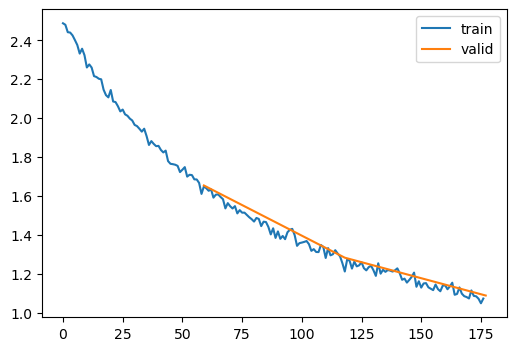

method is  <bound method MetricsCB.before_epoch of <miniai.learner.MetricsCB object at 0x0000025314B97F10>>
learn in  <__main__.Learner object at 0x0000025446BD2A60>
method is  <bound method ProgressCB.before_epoch of <miniai.learner.ProgressCB object at 0x0000025314384670>>
learn in  <__main__.Learner object at 0x0000025446BD2A60>
method is  <bound method DeviceCB.before_batch of <miniai.learner.DeviceCB object at 0x0000025314BA9EE0>>
learn in  <__main__.Learner object at 0x0000025446BD2A60>
method is  <bound method TrainCB.predict of <__main__.SGDCallback_TrainCB object at 0x0000025305198940>>
learn in  <__main__.Learner object at 0x0000025446BD2A60>
method is  <bound method TrainCB.get_loss of <__main__.SGDCallback_TrainCB object at 0x0000025305198940>>
learn in  <__main__.Learner object at 0x0000025446BD2A60>
method is  <bound method TrainCB.backward of <__main__.SGDCallback_TrainCB object at 0x0000025305198940>>
learn in  <__main__.Learner object at 0x0000025446BD2A60>
method is  

In [189]:
# Training with SGD as the optimizer
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = Learner(model, dls, F.cross_entropy, cbs=cbs)
learn.fit(3)

In [181]:


class AdamWithAnnealingCallback(TrainCB):
    def __init__(self, lr, wd=0., beta1=0.9, beta2=0.99, eps=1e-5, anneal_rate=0.97, n_inp=1):
        self.lr, self.wd, self.beta1, self.beta2, self.eps = lr, wd, beta1, beta2, eps
        self.anneal_rate = anneal_rate, self.n_inp = n_inp
        
        
    def step(self, learn): 
        # calls torch.no_grad() to disable gradient tracking
        with torch.no_grad():
            # iterates over the parameters
            for p in learn.model.parameters():
                self.reg_step(p)
                self.opt_step(p)
        self.i +=1
        
        
    def opt_step(self, p):
        if not hasattr(p, 'avg'): p.avg = torch.zeros_like(p.grad.data)
        if not hasattr(p, 'sqr_avg'): p.sqr_avg = torch.zeros_like(p.grad.data)
        
        # Update averages
        p.avg = self.beta1 * p.avg + (1 - self.beta1) * p.grad
        unbias_avg = p.avg / (1 - (self.beta1**(self.i + 1)))
        p.sqr_avg = self.beta2 * p.sqr_avg + (1 - self.beta2) * (p.grad**2)
        unbias_sqr_avg = p.sqr_avg / (1 - (self.beta2**(self.i + 1)))

        # Apply annealing to learning rate
        annealed_lr = self.lr * (self.anneal_rate ** self.i)

        # Update parameters
        p -= annealed_lr * unbias_avg / (unbias_sqr_avg.sqrt() + self.eps)    
    
    # Calculates the weight decay and updates the parameters
    # The purpose of weight decay is to prevent overfitting. It is calculated by multiplying the learning rate by the weight decay
    # essentially it is a penalty for having large weights (it reduces the value of the weights)
    # def reg_step(self, p):
    #     if self.wd != 0: p *= 1 - self.lr*self.wd
    def zero_grad(self, learn): learn.opt.zero_grad()

In [171]:
# runs the learning rate finder

class AdamWithAnnealingCallback(Callback):
    def __init__(self, lr, wd=0., beta1=0.9, beta2=0.99, eps=1e-5, anneal_rate=0.97):
        self.lr, self.wd, self.beta1, self.beta2, self.eps = lr, wd, beta1, beta2, eps
        self.anneal_rate = anneal_rate
        """
        Custom callback class for Adam optimizer with annealing.
        Args:
        - lr: Learning rate.
        - wd: Weight decay (default: 0.).
        - beta1: Coefficient for the exponential moving average of the gradient (default: 0.9).
        - beta2: Coefficient for the exponential moving average of the squared gradient (default: 0.99).
        - eps: Small value added to the denominator for numerical stability (default: 1e-5).
        - anneal_rate: Annealing rate for the learning rate (default: 0.97).
        """

    def before_batch(self):
        """
        Prepare optimizer parameters before each batch.
        This method is called before each batch during training to prepare the optimizer parameters.
        It initializes the `opt_params` attribute with a list of dictionaries, where each dictionary
        contains the 'avg' and 'sqr_avg' tensors for the gradients of the model parameters.
        
        Returns:
            None
        """
        if self.training:
            self.opt_params = [{'avg': torch.zeros_like(p.grad.data), 'sqr_avg': torch.zeros_like(p.grad.data)} 
                                if not hasattr(p, 'avg') else p.avg for p in self.learn.model.parameters()]

    def after_backward(self):
        """
        Performs the necessary computations and updates the model parameters after the backward pass.
        This method implements the Adam optimizer update rule for each parameter of the model.
        Returns:
            None
        """
        for p, opt_param in zip(self.learn.model.parameters(), self.opt_params):
            opt_param['avg'] = self.beta1 * opt_param['avg'] + (1 - self.beta1) * p.grad
            unbias_avg = opt_param['avg'] / (1 - (self.beta1 ** (self.n_iter + 1)))
            opt_param['sqr_avg'] = self.beta2 * opt_param['sqr_avg'] + (1 - self.beta2) * (p.grad ** 2)
            unbias_sqr_avg = opt_param['sqr_avg'] / (1 - (self.beta2 ** (self.n_iter + 1)))
            annealed_lr = self.lr * (self.anneal_rate ** self.n_iter)
            p.data -= annealed_lr * unbias_avg / (unbias_sqr_avg.sqrt() + self.eps)


In [182]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats, AdamWithAnnealingCallback(lr=6e-3)]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)


TypeError: cannot unpack non-iterable int object

In [183]:
# Training with SGD as the optimizer
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = Learner(model, dls, F.cross_entropy, cbs=cbs)
learn.fit(3)

method is  <bound method DeviceCB.before_fit of <miniai.learner.DeviceCB object at 0x0000025355822C70>>
learn in  <__main__.Learner object at 0x000002531DB4C1F0>
method is  <bound method MetricsCB.before_fit of <miniai.learner.MetricsCB object at 0x0000025444393C10>>
learn in  <__main__.Learner object at 0x000002531DB4C1F0>
method is  <bound method HooksCallback.before_fit of <miniai.activations.ActivationStats object at 0x0000025355822490>>
learn in  <__main__.Learner object at 0x000002531DB4C1F0>
method is  <bound method ProgressCB.before_fit of <miniai.learner.ProgressCB object at 0x0000025444294940>>
learn in  <__main__.Learner object at 0x000002531DB4C1F0>


method is  <bound method MetricsCB.before_epoch of <miniai.learner.MetricsCB object at 0x0000025444393C10>>
learn in  <__main__.Learner object at 0x000002531DB4C1F0>
method is  <bound method ProgressCB.before_epoch of <miniai.learner.ProgressCB object at 0x0000025444294940>>
learn in  <__main__.Learner object at 0x000002531DB4C1F0>


method is  <bound method DeviceCB.before_batch of <miniai.learner.DeviceCB object at 0x0000025355822C70>>
learn in  <__main__.Learner object at 0x000002531DB4C1F0>
method is  <bound method TrainCB.predict of <__main__.AdamWithAnnealingCallback object at 0x000002531DB012B0>>
learn in  <__main__.Learner object at 0x000002531DB4C1F0>


AttributeError: 'AdamWithAnnealingCallback' object has no attribute 'n_inp'

In [13]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GeneralRelu()
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GeneralRelu()
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GeneralRelu()
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GeneralRelu()
  )
  (4): Sequential(
    (0): Conv2d(64, 10, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (5): Flatten(start_dim=1, end_dim=-1)
)

In [55]:
# look at this chat for more inforamtion 
# https://chat.openai.com/c/6e02c7b8-363e-4fcd-b60d-6a41020d825d
# See for reference on callbacks C:\temp\resolver101757\posts\initialization_neural_networks\index.ipynb


In [57]:
# Training with SGD as the optimizer
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=6e-3, cbs=cbs, opt_func=AdamWithAnnealing)
learn.fit(3)

AttributeError: learn